In [1]:
import matplotlib.pyplot as plt
import time

In [4]:
from common_functions import *

In [50]:
from encodec import EncodecModel
from encodec.utils import convert_audio
import torchaudio
import torch
import resampy

In [81]:
def encodec(x, model):
    wav = torch.tensor(np.reshape(x,-1)).unsqueeze(0).unsqueeze(0)
    wav = convert_audio(wav, 16256, model.sample_rate, model.channels)
    with torch.no_grad():
        encoded_frames = model.encode(wav)
    decoded_wav = np.array(model.decode(encoded_frames).detach())
    decoded_wav = resampy.resample(decoded_wav,24000,16256)
    return decoded_wav

def load_mini_speech_commands_encodec():
    DATASET_PATH = 'data/mini_speech_commands'

    data_dir = pathlib.Path(DATASET_PATH)
    if not data_dir.exists():
      tf.keras.utils.get_file(
          'mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True,
          cache_dir='.', cache_subdir='data')

    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=data_dir,
        batch_size=None,
        validation_split=0.2,
        seed=0,
        output_sequence_length=16256,
        subset='both')
    
    model = EncodecModel.encodec_model_24khz()
    model.set_target_bandwidth(1.5) 
    
    X = []
    y = []
    Xv = []
    yv = []
    for xi,yi in train_ds:
        xi = encodec(xi,model)
        X.append(np.expand_dims(STFT(xi),0))
        y.append(yi)
    for xi,yi in val_ds:
        xi = encodec(xi,model)
        Xv.append(np.expand_dims(STFT(xi),0))
        yv.append(yi)
    X = np.vstack(X)
    y = np.vstack(y)
    Xv = np.vstack(Xv)
    yv = np.vstack(yv)
    
    return X, y, Xv, yv

In [82]:
# X, y, Xv, yv = load_mini_speech_commands_encodec()
# np.save('encodec_transformed_data/X',X)
# np.save('encodec_transformed_data/y',y)
# np.save('encodec_transformed_data/Xv',Xv)
# np.save('encodec_transformed_data/yv',yv)

X = np.load('encodec_transformed_data/X.npy')
y = np.load('encodec_transformed_data/y')
Xv = np.load('encodec_transformed_data/Xv')
yv = np.load('encodec_transformed_data/yv')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [84]:
np.save('encodec_transformed_data/X',X)
np.save('encodec_transformed_data/y',y)
np.save('encodec_transformed_data/Xv',Xv)
np.save('encodec_transformed_data/yv',yv)

In [86]:
model = models.Sequential([
    layers.Input(shape=(128,128,1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                        

In [87]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [88]:
train_acc = [];
test_acc = [];
elapsed_time = [];

2022-12-05 14:56:25.729778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2022-12-05 14:56:26.628236: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-05 14:56:26.796259: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb1971bf050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-05 14:56:26.796286: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2022-12-05 14:56:26.801136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-05 14:56:26.876479: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-05 14:56:26.948585: I tensorflow/compiler/jit/xla_compilati

50/50 [==============================] - 0s 4ms/step - loss: 1.8549 - accuracy: 0.7638


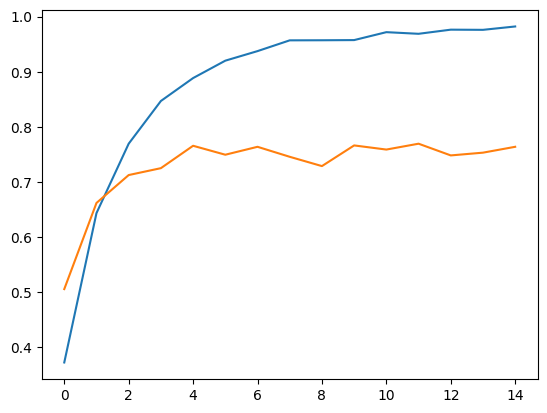

In [91]:
for i_iter in range(15):
    t = time.process_time()
    train_history = model.fit(x=X, y=y, epochs=1, batch_size=64);
    elapsed_time.append(time.process_time()-t)
    _, test_acc_i = model.evaluate(x=Xv, y=yv)
    train_acc.append(train_history.history['accuracy'][0])
    test_acc.append(test_acc_i)
plt.plot(np.vstack(train_acc))
plt.plot(np.vstack(test_acc))

In [92]:
print(np.median(elapsed_time), "seconds/iteration")
print(np.median(test_acc[-5:]), "test accuracy")

2.869480199999998 seconds/iteration
0.7587500214576721 test accuracy
